# Bert Regressor
学習中にtrain_lossとeval_lossを同時に見れるようにする．

In [1]:
import tensorflow as tf
import modeling
import tokenization
import optimization
import run_regressor
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


## Preprocessing for Data
give indice to reviewerID, asin

In [2]:
train_df = pd.read_csv('/home/ubuntu/glue_data/ARD/train.tsv','\t')
dev_df = pd.read_csv('/home/ubuntu/glue_data/ARD/dev.tsv','\t')
test_df = pd.read_csv('/home/ubuntu/glue_data/ARD/test.tsv','\t')
all_df = train_df.append(dev_df).append(test_df)

In [3]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(np.hstack((all_df.asin,all_df.reviewerID)))
def add_indice_cols(df):
    df_ = df.copy()
    df_['user_id'] = label_encoder.transform(df_['reviewerID'])
    df_['item_id'] = label_encoder.transform(df_['asin'])
    return df_

In [4]:
train_df = add_indice_cols(train_df)
dev_df = add_indice_cols(dev_df)
test_df = add_indice_cols(test_df)

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
train_df, dev_df = train_test_split(train_df.append(dev_df), test_size=0.33, shuffle=True)

In [7]:
train_df.to_csv('/home/ubuntu/glue_data/ARD/train.tsv',sep='\t',index=None)
dev_df.to_csv('/home/ubuntu/glue_data/ARD/dev.tsv',sep='\t',index=None)
test_df.to_csv('/home/ubuntu/glue_data/ARD/test.tsv',sep='\t',index=None)

## Defining args

In [8]:
bert_config_file = '/home/ubuntu/bert_models/uncased_L-12_H-768_A-12/bert_config.json'
bert_config = modeling.BertConfig.from_json_file(bert_config_file)
vocab_file = '/home/ubuntu/bert_models/uncased_L-12_H-768_A-12/vocab.txt'
max_seq_length = 128
train_batch_size = 32
eval_batch_size = 32
predict_batch_size = 32
num_train_epochs=5.0
warmup_proportion = 0.1

''' tpu '''
save_checkpoints_steps = 1000
iterations_per_loop = 1000

DATA_DIR = '/home/ubuntu/glue_data/ARD/'
BERT_BASE_DIR = '/home/ubuntu/bert_models/uncased_L-12_H-768_A-12'
INIT_CHECKPOINT = '/home/ubuntu/bert_models/uncased_L-12_H-768_A-12/bert_model.ckpt'

## Defining methods

In [9]:
# using only textual information
def create_model(bert_config, is_training, input_ids, input_mask, segment_ids,values):
    """Creates a regression model."""
    model = modeling.BertModel(
      config=bert_config,
      is_training=is_training,
      input_ids=input_ids,
      input_mask=input_mask,
      token_type_ids=segment_ids)

    output_layer = model.get_pooled_output()

    hidden_size = output_layer.shape[-1].value

    output_weights = tf.get_variable(
      "output_weights", [1, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

    output_bias = tf.get_variable(
      "output_bias", [1], initializer=tf.zeros_initializer())

    with tf.variable_scope("loss"):
        if is_training:
          # I.e., 0.1 dropout
          output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)

        logits = tf.matmul(output_layer, output_weights, transpose_b=True)
        logits = tf.nn.bias_add(logits, output_bias)
        logits = tf.squeeze(logits)
        loss = tf.losses.mean_squared_error(values,logits)

    return (loss, logits)

レビュワー・商品のコンテクストを取り入れる

In [10]:
def get_distribution(df):
    user_cnt_dist = df.groupby(['user_id','overall'])['helpful_rate'].count().unstack(1,fill_value=0)
    item_cnt_dist = df.groupby(['item_id','overall'])['helpful_rate'].count().unstack(1,fill_value=0)
    all_cnt_dist = user_cnt_dist.append(item_cnt_dist).sort_index()
    all_dist = all_cnt_dist.apply(lambda x:x/sum(x),1)
    return all_dist

In [11]:
# using textual and user-item contextual information
def create_model2(bert_config, is_training, input_ids, input_mask, segment_ids,values,user_id,item_id,overall):
    """Creates a regression model."""
    # text information
    model = modeling.BertModel(
      config=bert_config,
      is_training=is_training,
      input_ids=input_ids,
      input_mask=input_mask,
      token_type_ids=segment_ids)

    output_layer = model.get_pooled_output()
    
    
    # User and Item and this rating information
    user_item_emb = tf.constant(get_distribution(all_df).values,dtype=tf.float32)
    user_dist = tf.nn.embedding_lookup(user_item_emb,user_id)
    item_dist = tf.nn.embedding_lookup(user_item_emb,item_id)
    rating_onehot = tf.one_hot(overall-1,depth=5,dtype=tf.float32)
    historical_ = tf.concat([user_dist,item_dist,rating_onehot],1)
    historical = tf.layers.dense(historical_,historical_.shape[-1].value)
    
    # concat
    bert_historical = tf.concat([output_layer,historical],1)
    
    hidden_size = bert_historical.shape[-1].value
    
    output_weights = tf.get_variable(
      "output_weights", [1, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

    output_bias = tf.get_variable(
      "output_bias", [1], initializer=tf.zeros_initializer())

    with tf.variable_scope("loss"):
        if is_training:
          # I.e., 0.1 dropout
          output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)

        logits = tf.matmul(bert_historical, output_weights, transpose_b=True)
        logits = tf.nn.bias_add(logits, output_bias)
        logits = tf.squeeze(logits)
        loss = tf.losses.mean_squared_error(values,logits)

    return (loss, logits)

In [12]:
def model_fn_builder(bert_config, init_checkpoint, learning_rate,
                     num_train_steps, num_warmup_steps, use_tpu=False):
  """Returns `model_fn` closure"""

  def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    """The `model_fn` for TPUEstimator."""
    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    values = features["values"]
    user_id = features["user_id"]
    item_id = features["item_id"]
    overall = features["overall"]

    is_training = (mode == tf.estimator.ModeKeys.TRAIN)

#     (total_loss, logits) = create_model2(
#         bert_config, is_training, input_ids, input_mask, segment_ids, values,user_id,item_id,overall)
    (total_loss, logits) = create_model(
        bert_config, is_training, input_ids, input_mask, segment_ids, values)

    tvars = tf.trainable_variables()
    initialized_variable_names = {}
    scaffold_fn = None
    if init_checkpoint:
        (assignment_map, initialized_variable_names
              ) = modeling.get_assignment_map_from_checkpoint(tvars, init_checkpoint)
        if use_tpu:

            def tpu_scaffold():
                tf.train.init_from_checkpoint(init_checkpoint, assignment_map)
                return tf.train.Scaffold()

            scaffold_fn = tpu_scaffold
        else:
            tf.train.init_from_checkpoint(init_checkpoint, assignment_map)

    output_spec = None
    if mode == tf.estimator.ModeKeys.TRAIN:

        train_op = optimization.create_optimizer(total_loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu)

        output_spec = tf.contrib.tpu.TPUEstimatorSpec(
                              mode=mode,
                              loss=total_loss,
                              train_op=train_op,
                              scaffold_fn=scaffold_fn)
    elif mode == tf.estimator.ModeKeys.EVAL:

        def metric_fn(total_loss, logits):
            return {
                "eval_loss": tf.metrics.mean_squared_error(labels=values,predictions=logits),
            }

        eval_metrics = (metric_fn, [total_loss, logits])
        output_spec = tf.contrib.tpu.TPUEstimatorSpec(
          mode=mode,
          loss=total_loss,
          eval_metrics=eval_metrics,
          scaffold_fn=scaffold_fn)
    else:
        output_spec = tf.contrib.tpu.TPUEstimatorSpec(
            mode=mode, predictions=logits, scaffold_fn=scaffold_fn)
    return output_spec

  return model_fn


In [13]:
def input_fn_builder(features, seq_length, is_training, drop_remainder):
    """Creates an `input_fn` closure to be passed to TPUEstimator."""

    all_input_ids = []
    all_input_mask = []
    all_segment_ids = []
    all_label_ids = []
    all_user_ids = []
    all_item_ids = []
    all_overalls = []

    for feature in features:
        all_input_ids.append(feature.input_ids)
        all_input_mask.append(feature.input_mask)
        all_segment_ids.append(feature.segment_ids)
        all_label_ids.append(feature.label_id)
        all_user_ids.append(feature.user_id)
        all_item_ids.append(feature.item_id)
        all_overalls.append(feature.overall)
  
    def input_fn(params):
        """The actual input function."""
        batch_size = params["batch_size"]

        num_examples = len(features)

        # This is for demo purposes and does NOT scale to large data sets. We do
        # not use Dataset.from_generator() because that uses tf.py_func which is
        # not TPU compatible. The right way to load data is with TFRecordReader.
        d = tf.data.Dataset.from_tensor_slices({
            "input_ids":
                tf.constant(
                    all_input_ids, shape=[num_examples, seq_length],
                    dtype=tf.int32),
            "input_mask":
                tf.constant(
                    all_input_mask,
                    shape=[num_examples, seq_length],
                    dtype=tf.int32),
            "segment_ids":
                tf.constant(
                    all_segment_ids,
                    shape=[num_examples, seq_length],
                    dtype=tf.int32),
            "values":
                tf.constant(all_label_ids, shape=[num_examples], dtype=tf.float32),
            "user_id":
                tf.constant(all_user_ids,shape=[num_examples],dtype=tf.int32),
            "item_id":
                tf.constant(all_item_ids,shape=[num_examples],dtype=tf.int32),
            "overall":
                tf.constant(all_overalls,shape=[num_examples],dtype=tf.int32),
        })

        if is_training:
            d = d.repeat()
            d = d.shuffle(buffer_size=100)

        d = d.batch(batch_size=batch_size, drop_remainder=drop_remainder)
        return d

    return input_fn

## Construct Estimator

In [14]:
OUTPUT_DIR = '/home/ubuntu/tmp/bert_TrEv/'

In [15]:
processor = run_regressor.ArdProcessor()
tokenizer = tokenization.FullTokenizer(vocab_file=vocab_file,do_lower_case=True)

In [16]:
train_examples = processor.get_train_examples(DATA_DIR)
num_train_steps = int(len(train_examples) / train_batch_size * num_train_epochs)
num_warmup_steps = int(num_train_steps * warmup_proportion)

In [17]:
# tpu configuration
tpu_cluster_resolver = None
is_per_host = tf.contrib.tpu.InputPipelineConfig.PER_HOST_V2
run_config = tf.contrib.tpu.RunConfig(
  cluster=tpu_cluster_resolver,
  master=None,
  model_dir=OUTPUT_DIR,
  save_checkpoints_steps=save_checkpoints_steps,
  tpu_config=tf.contrib.tpu.TPUConfig(
      iterations_per_loop=iterations_per_loop,
      num_shards=None,
      per_host_input_for_training=is_per_host))


In [18]:
model_fn = model_fn_builder(bert_config=bert_config,
                            init_checkpoint=INIT_CHECKPOINT,
                            learning_rate=2e-5,
                            num_train_steps=num_train_steps,
                            num_warmup_steps=num_warmup_steps)

In [19]:
estimator = tf.contrib.tpu.TPUEstimator(
    use_tpu=False,
    model_fn=model_fn,
    config=run_config,
    train_batch_size=train_batch_size,
    eval_batch_size=eval_batch_size,
    predict_batch_size=predict_batch_size)

INFO:tensorflow:Using config: {'_model_dir': '/home/ubuntu/tmp/bert_TrEv/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f20e5420048>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1, '_tpu_config': TPUConfig(iterations_per_loop=1000, num_shards=None, num_cores_per_replica=None, per_host_input_for_training=3, tpu_job_name=None, initial_infeed_sleep

## Training and Evaluation 

In [20]:
# Configuration
steps_per_eval = 100 #training_step何回につき評価を行うか

In [21]:
train_examples = processor.get_train_examples(DATA_DIR)

train_features = run_regressor.convert_examples_to_features(train_examples,max_seq_length=max_seq_length,tokenizer=tokenizer)

train_input_fn = input_fn_builder(train_features,max_seq_length,is_training=True,drop_remainder=True)

INFO:tensorflow:Writing example 0 of 33500
INFO:tensorflow:*** Example ***
INFO:tensorflow:guid: train-0
INFO:tensorflow:tokens: [CLS] i have a nano ipod , while my sons have the video ipod ##s . i drop mine a lot , cutting the lawn , etc , and nano ##s are just about ind ##est ##ru ##ct ##ible . i keep all my music on the computer , and about 10 hours worth on the nano . i love it . i searched carefully , first reading every review of a small stereo unit to play the ipod ##s . next , i went to several stores and tested them all , with my ipod , playing bob dylan music . i download his concerts , so the sound quality is not always the best ; which is a great way to test the various units [SEP]
INFO:tensorflow:input_ids: 101 1045 2031 1037 28991 26322 1010 2096 2026 4124 2031 1996 2678 26322 2015 1012 1045 4530 3067 1037 2843 1010 6276 1996 10168 1010 4385 1010 1998 28991 2015 2024 2074 2055 27427 4355 6820 6593 7028 1012 1045 2562 2035 2026 2189 2006 1996 3274 1010 1998 2055 2184 2847 

In [22]:
eval_examples = processor.get_dev_examples(DATA_DIR)
eval_features = run_regressor.convert_examples_to_features(eval_examples,max_seq_length=max_seq_length,tokenizer=tokenizer)
# This tells the estimator to run through the entire set.
eval_steps = None
eval_input_fn = input_fn_builder(eval_features,max_seq_length,is_training=False,drop_remainder=False)

INFO:tensorflow:Writing example 0 of 16500
INFO:tensorflow:*** Example ***
INFO:tensorflow:guid: dev-0
INFO:tensorflow:tokens: [CLS] as another person coming from the official un - lit leather case ( due to the re ##boot ##ing issue that caused it to be pulled from amazon ' s store ) i wanted something similar , without a light , that didn ' t use the battery bay clips causing all the issues . i finally stumbled upon this case and decided to take a chance based on other reviews . i consider myself " spoiled " by the simplicity and design of the old official leather case , so weed ##ing through the multitude of low - quality or over - the - top cases available , i was glad to see on manufacturer focusing on a simple yet well - built case . [SEP]
INFO:tensorflow:input_ids: 101 2004 2178 2711 2746 2013 1996 2880 4895 1011 5507 5898 2553 1006 2349 2000 1996 2128 27927 2075 3277 2008 3303 2009 2000 2022 2766 2013 9733 1005 1055 3573 1007 1045 2359 2242 2714 1010 2302 1037 2422 1010 2008 213

In [23]:
current_step = 0
while current_step <= num_train_steps:
    estimator.train(input_fn=train_input_fn,steps=steps_per_eval)
    eval_result = estimator.evaluate(input_fn=eval_input_fn, steps=eval_steps)
    current_step = current_step + steps_per_eval
    print("ステップ：{}".format(current_step))
    print(eval_result)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Running train on CPU
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/ubuntu/tmp/bert_TrEv/model.ckpt-0
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /home/ubuntu/tmp/bert_TrEv/model.ckpt.
INFO:tensorflow:Saving checkpoints for 100 into /home/ubuntu/tmp/bert_TrEv/model.ckpt.
INFO:tensorflow:Loss for final step: 0.03993911.
INFO:tensorflow:training_loop marked as finished
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Running eval on CPU
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-12-31-08:53:24
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/ubuntu/tmp/bert_TrEv/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
IN

KeyboardInterrupt: 

## Prediction

In [33]:
predict_examples = processor.get_test_examples(DATA_DIR)

In [34]:
predict_features = run_regressor.convert_examples_to_features(predict_examples,max_seq_length=max_seq_length,tokenizer=tokenizer)

INFO:tensorflow:Writing example 0 of 3191
INFO:tensorflow:*** Example ***
INFO:tensorflow:guid: test-0
INFO:tensorflow:tokens: [CLS] i purchased this tablet out of enthusiasm for it ' s built in beats audio . while it does have beats audio built in , it is a very limited feature . the overall movement through the tablet is very smooth . however , i noticed early on that what should be beautiful hd graphics were grain ##y and down right ugly . i usually get nice photos on my facebook wall . on my hp laptop , and my samsung tablet the photos look beautiful , but on the slate 7 the pictures are terrible . that was my first concern . second concern , the slate 7 didn ' t come with a built in video player . the primary reason i started using [SEP]
INFO:tensorflow:input_ids: 101 1045 4156 2023 13855 2041 1997 12024 2005 2009 1005 1055 2328 1999 10299 5746 1012 2096 2009 2515 2031 10299 5746 2328 1999 1010 2009 2003 1037 2200 3132 3444 1012 1996 3452 2929 2083 1996 13855 2003 2200 5744 1012 2

In [36]:
predict_input_fn = input_fn_builder(predict_features,max_seq_length,is_training=False,drop_remainder=False)

In [37]:
result = estimator.predict(input_fn=predict_input_fn)

In [38]:
prediction = np.array(list(result))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Running infer on CPU
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/ubuntu/tmp/bert_TrEv/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:prediction_loop marked as finished
INFO:tensorflow:prediction_loop marked as finished


In [39]:
labels = np.array([i.label for i in predict_examples])

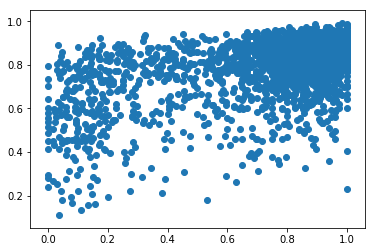

In [40]:
plt.scatter(labels,prediction)

In [41]:
from sklearn.metrics import mean_squared_error,r2_score

In [42]:
print(mean_squared_error(y_pred=prediction,y_true=labels))

print(r2_score(y_pred=prediction,y_true=labels))

0.04335372527463028
0.2801617327273611


(array([   9.,   17.,   20.,   59.,   73.,  127.,  231.,  591., 1460.,
         604.]),
 array([0.11088897, 0.19888072, 0.28687247, 0.37486422, 0.46285597,
        0.55084772, 0.63883947, 0.72683121, 0.81482296, 0.90281471,
        0.99080646]),
 <a list of 10 Patch objects>)

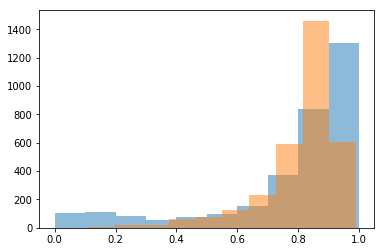

In [43]:
plt.hist(labels,alpha=0.5)
plt.hist(prediction,alpha=0.5)

In [ ]:
test_df = pd.read_csv('/home/ubuntu/glue_data/ARD/test.tsv',delimiter='\t')